In [1]:
import pandas as pd
import numpy as np
import csv 
import string
import nltk 
import re 
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import sys
import warnings
from os import path
import ast
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, average_precision_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import jaccard_score
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import time
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from skmultilearn.adapt import BRkNNaClassifier
from sklearn.linear_model import RidgeClassifierCV

pd.options.display.max_seq_items = 2000
pd.options.display.max_colwidth = 90
pd.options.display.max_rows = 999

loggingFile = './experiment//TitleBody3GramTFIDF.txt'
binaryBodyTitle = './experiment/binaryBodyTitle.csv'
template = './experiment/dfTeste.csv'

In [2]:
# -*- coding: utf-8 -*-
# Importing required Library
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

In [3]:


def create_dataset(n_sample=1000):
    ''' 
    Create a unevenly distributed sample data set multilabel  
    classification using make_classification function
    
    args
    nsample: int, Number of sample to be created
    
    return
    X: pandas.DataFrame, feature vector dataframe with 10 features 
    y: pandas.DataFrame, target vector dataframe with 5 labels
    '''
    X, y = make_classification(n_classes=5, class_sep=2, 
                           weights=[0.1,0.025, 0.205, 0.008, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=10, n_clusters_per_class=1, n_samples=1000, random_state=10)
    y = pd.get_dummies(y, prefix='class')
    return pd.DataFrame(X), y

def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified
    
  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target



In [4]:
#organizing data_frame to issue order
def organize():
    data_classes = pd.read_csv(binaryBodyTitle, header = 0, sep=";")
    data_classes

    del data_classes['prIssue']
    del data_classes['issueTitle']
    del data_classes['issueBody']

    data_classes.rename(columns={'issueComments': 'prComments','Comments': 'prCodeReviewComments','issueTitleLink': 'issueTitle','issueBodyLink': 'issueBody','issueCommentsLink': 'issue_Comments','pr': 'prNumber','issue': 'issueNumber', 'Title': 'prTitle','Body': 'prBody'}, inplace=True)
    categories = data_classes.columns.values.tolist()


    data_classes = data_classes[['issueNumber', 'prNumber', 'issueTitle', 'issueBody', 'issue_Comments',
                            'prTitle','prBody','prComments','prCodeReviewComments','commitMessage','isPR','isTrain',
                             'Google Common','Test','SO','IO','UI','Network','Security',
                            'OpenOffice Documents','Database','Utils','PDF','Logging','Latex']]

    data_classes['issueNumber'] = data_classes['issueNumber'].astype('Int64')
    
    return data_classes

In [5]:
#Filtering issues with PRs
def filtering(data_classes):
    IssuePRDataset = data_classes[data_classes["isTrain"] == 0]

    #invalid number of issue = NaN
    IssuePRDataset = IssuePRDataset.drop([1805])

    categories = IssuePRDataset.columns.values.tolist()
    
    return categories, IssuePRDataset

In [6]:
# RQ1.a - o quão sensível o resultado é em relação ao algoritmo? 
#vários algoritmos - BinaryRelevance
#todas as palavras, bootstrap, unigram 
#somente o título
def dataset_config(IssuePRDataset):
    data_test1 = IssuePRDataset[['issueNumber','prNumber','issueTitle','Google Common', 'Test', 'SO', 'IO', 'UI', 'Network', 'Security', 
                           'OpenOffice Documents', 'Database', 'Utils', 'PDF', 'Logging', 'Latex']].copy()

    data_test1["corpus"] = data_test1["issueTitle"].map(str)
    del data_test1["issueTitle"]

    #removing utils because we won't to predict a so simple API that is basically used in all PRs
    del data_test1["Utils"]

    data_test1 = data_test1.reset_index(drop=True)
    
    return data_test1

In [7]:
#preprocessing text

#We first convert the comments to lower-case 
#then use custom made functions to remove html-tags, punctuation and non-alphabetic characters from the TitleBody.

def clean_data(data_test1):
    if not sys.warnoptions:
        warnings.simplefilter("ignore")

    def cleanHtml(sentence):
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, ' ', str(sentence))
        return cleantext

    def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
        cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
        cleaned = cleaned.strip()
        cleaned = cleaned.replace("\n"," ")
        return cleaned

    def keepAlpha(sentence):
        alpha_sent = ""
        for word in sentence.split():
            alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
            alpha_sent += alpha_word
            alpha_sent += " "
        alpha_sent = alpha_sent.strip()
        return alpha_sent

    #function pra remover palavras com menos de 3 tokens

    data_test1['corpus'] = data_test1['corpus'].str.lower()
    data_test1['corpus'] = data_test1['corpus'].apply(cleanHtml)
    data_test1['corpus'] = data_test1['corpus'].apply(cleanPunc)
    data_test1['corpus'] = data_test1['corpus'].apply(keepAlpha)
    
    return data_test1


In [8]:
#### removing stopwords

def remove_stop_words():
    stop_words = set(stopwords.words('english'))
    stop_words.update(['pr','zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within','jabref','org','github','com','md','https','ad','changelog','','joelparkerhenderson','localizationupd',' localizationupd','localizationupd ','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the','Mr', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'])
    #stop_words.update(['i', 'me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the","Mr", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

    re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

    return re_stop_words

In [9]:
def removeStopWords(sentence, re_stop_words):
    #global re_stop_words
    #print(sentence)
    return re_stop_words.sub(" ", sentence)

#removing words with less than 3 characters
#data_classes['titleBody'] = data_classes['titleBody'].str.findall('\w{3,}').str.join(' ')

In [10]:
def apply_stem(data_test1):
    stemmer = SnowballStemmer("english")
    
    def stemming(sentence):
        stemSentence = ""
        for word in sentence.split():
            stem = stemmer.stem(word)
            stemSentence += stem
            stemSentence += " "
        stemSentence = stemSentence.strip()
        return stemSentence
    
    data_test1['corpus'] = data_test1['corpus'].apply(stemming)
    print(data_test1['corpus'])
    
    return data_test1


In [11]:
#TF-ID
def run_tf_idf(data, configurationTFIDF, num_feature, tfIDFoutputFile):
    #we need to text max_feature with 10, 20, 25, 50 
    #, max_features=num_feature
    vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range = configurationTFIDF, max_features=num_feature)
        
    tf_idf_results = vectorizer.fit_transform(data['corpus'])

    features = vectorizer.get_feature_names()

    #print(features)

    scores = (tf_idf_results.toarray())
    output_tf_idf = pd.DataFrame(scores)
    
    output_tf_idf = pd.concat([data['issueNumber'], output_tf_idf], axis=1)

    output_tf_idf.to_csv(tfIDFoutputFile, encoding='utf-8', header=False, index=False, sep=',')


    # remove words occuring less than 5 times
    #tfidf = TfidfVectorizer(min_df=5)
    #you can also remove common words:

    # remove words occuring in more than half the documents
    #tfidf = TfidfVectorizer(max_df=0.5)
    #you can also remove stopwords like this:
    

In [12]:
#analyzing frequency of TOP 50 terms

def analyze_top(data, termFrequencyTop50):
    docs = data['corpus'].tolist()

    cv = CountVectorizer()
    cv_fit=cv.fit_transform(docs)

    #print(cv.get_feature_names())
    #print(cv_fit.toarray())

    word_list = cv.get_feature_names()   

    count_list = cv_fit.toarray().sum(axis=0)
    term_frequency = dict(zip(word_list,count_list))

    a = sorted(term_frequency.items(), key=lambda x: x[1], reverse=True) 
    
    #print('SIZE OF TERMS', len(a))
    
    top50 = a[:100]
    df_frequency = pd.DataFrame(top50, columns =['term', 'frequency'])  

    #print(df_frequency)

    df_frequency.to_csv(termFrequencyTop50, encoding='utf-8', header=False, index=False, sep=',')

    sns.set(font_scale = 2)
    plt.figure(figsize=(18,17))
    plt.xticks(rotation=90)
    plt.title("Frequency of terms ")
    plt.ylabel('term', fontsize=20)
    plt.xlabel('frequency', fontsize=20)
    ax = sns.barplot(x="frequency", y="term", data=df_frequency)
    
    return docs


In [13]:
#merging features TF-IDF with data_frame
def merging(data_test1, tfIDFoutputFile):
    feature = pd.read_csv(tfIDFoutputFile, header=None, sep=",")
    feature.rename(columns={0: 'issueNumber'}, inplace=True)

    data_classifier = data_test1.join(feature, lsuffix='issueNumber', rsuffix='issueNumber')

    categories = data_classifier.columns.values.tolist()
    
    return data_classifier, categories


In [14]:
def eval_metrics(predictions, probabilities, y_test):
    
    y_pred = predictions.values
    y_proba = probabilities.values

    #receiving the y_test true value from each pull request
    y_true = y_test.to_numpy()

    print("Accuracy Score")
    acc_ml = accuracy_score(y_true, y_pred)
    print(acc_ml)

    print("---------")
    print("")

    print("Accuracy Score not normalized")
    acc_score = accuracy_score(y_true, y_pred, normalize=False)
    print(acc_score)

    print("---------")
    print("")

    print("zero_one_loss")
    zeroOne = zero_one_loss(y_true, y_pred)
    print(zeroOne)

    print("---------")
    print("")

    print("Fmeasure Score")
    fmeasure_score = f1_score(y_true,y_pred, average='micro')
    #fmeasure_score = f1_score(y_true,y_pred, average='macro')
    print(fmeasure_score)

    print("---------")
    print("")

    #AUC-PR
    print("AUC-PR")
    pr_score = average_precision_score(y_true,y_proba,average='micro')
    print(pr_score)
    #pr_score = average_precision_score(y_true,y_proba,average='macro')

    print("---------")
    print("")


    print("hamming loss average")
    hamming_loss = skm.hamming_loss(y_true, y_pred)
    print(hamming_loss)

    print("---------")
    print("")

    print("Jaccard samples")
    jaccard_score_samples = jaccard_score(y_true, y_pred, average='samples')
    print(jaccard_score_samples)

    print("---------")
    print("")


    print("Jaccard macro")
    jaccard_macro = jaccard_score(y_true, y_pred, average='micro')
    print(jaccard_macro)
    #jaccard_score(y_true, y_pred, average=None)

    print("---------")
    print("")

    return y_true, y_proba, y_pred, acc_ml, acc_score, zeroOne, fmeasure_score, pr_score, hamming_loss, jaccard_score_samples, jaccard_macro

In [15]:
def plot_classes(probability, y_true, y_test):
    precision = dict()
    recall = dict()
    average_precision = dict()

    n_classes = y_test.shape[1]

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], probability[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], probability[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),probability.ravel())

    average_precision["micro"] = average_precision_score(y_true, probability, average="micro")

    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))


In [16]:
import io
def confusion_matrix(y_true, y_pred, confusionMatrix, i):

    data = multilabel_confusion_matrix(y_true, y_pred)
    
    labels = ['Google Common', 'Test', 'SO', 'IO', 'UI', 'Network',
              'Security', 'OpenOffice Documents', 'Database','PDF',
              'Logging','Latex']
      
    metrics = pd.DataFrame()
    line = []
    dataLine = ""
    dataLine = "Label, TN, FP, FN, TP"
    line.append((dataLine))

    for j in range (0,12):
        print(j)
        row = data[j]
        dataLine=""
        dataLine = labels[j] 
        print(dataLine)
        for x in np.nditer(row):
            dataLine = dataLine + "," + str(x)
            print(dataLine)
        line.append((dataLine))
        print(line)
        
        metrics = pd.DataFrame(line)
    
    metrics.to_csv(confusionMatrix + str(i) +'.csv' , encoding='utf-8', header=True, index=False , sep=',')
    

In [17]:
#build the model 

def build_model(test_type):

    if test_type == "DecisionTree":
        clf = BinaryRelevance(classifier=DecisionTreeClassifier(), require_dense = [False, True])
        #clf = ClassifierChain(classifier=DecisionTreeClassifier(), require_dense = [False, True])
    if test_type == "LogisticRegression":
        clf = BinaryRelevance(classifier=LogisticRegression(random_state=0), require_dense = [False, True])
        #clf = ClassifierChain(classifier=LogisticRegression(random_state=0), require_dense = [False, True])
    if test_type == "RandomForest": 
        clf = BinaryRelevance(classifier=RandomForestClassifier(criterion='entropy',max_depth= 50, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 50), require_dense = [False, True])
        #clf = ClassifierChain(classifier=RandomForestClassifier(criterion='entropy',max_depth= 50, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 50), require_dense = [False, True])
    if test_type == "MLPClassifier":
        clf = BinaryRelevance(classifier=MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1), require_dense = [False, True])
        #clf = ClassifierChain(classifier=MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1), require_dense = [False, True])
    if test_type == "MLkNN":
        clf = BinaryRelevance(MLkNN(k=3))
        #clf = ClassifierChain(classifier=MLkNN(k=3))

    #This three works without probability
    if test_type == "LinearSVC":
        clf = BinaryRelevance(classifier=LinearSVC(), require_dense = [False, True])
    if test_type == "GaussianNB":
        clf = BinaryRelevance(classifier=GaussianNB(), require_dense = [False, True])
    if test_type == "RidgeClassifierCV":
        clf = BinaryRelevance(classifier=RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]), require_dense = [False, True]) 
    if test_type == "BRkNNaClassifier":
        clf = BinaryRelevance(BRkNNaClassifier(k=3))

        
    return clf

In [18]:
def save_metrics(y_true, y_pred, acc_ml,acc_score,zeroOne,pr_score,hamming_loss,jaccard_score_samples,jaccard_macro, modelMatrix, metrics_by_class, i, configurationTFIDF ,num_feature ,stop_word ,size_test,test_type):

    line=[] 
    # line to csv report file
    
    names = ['Google Common',
'Test',
'SO',
'IO',
'UI',
'Network',
'Security',
'OpenOffice Documents',
'Database',
'PDF',
'Logging',
'Latex']
    

    prec, rec, fscore, sup = precision_recall_fscore_support(y_true,y_pred, average='micro')


    arr = [acc_ml,acc_score,zeroOne,pr_score,hamming_loss,jaccard_score_samples,jaccard_macro,prec,rec, fscore]
    columns = ['Accuracy','Acc-Score','zero_one_loss','AUC-PR','hamming loss average','Jaccard samples','Jaccard macro','Precision','Recall','Fmeasure']
  
    df_metrics2 = pd.DataFrame([arr],columns=columns)
    print(df_metrics2)

    print("---------")
    print("")

    x = precision_recall_fscore_support(y_true,y_pred, average=None)
    print("")
    print("")

    df_metrics_by_class = pd.DataFrame.from_records(x, columns=names, index=['precision','recall','f-measure','samples_tested'])
    print(df_metrics_by_class)

    print("---------")
    print("")

    df_metrics2.to_csv(modelMatrix, encoding='utf-8', header=True, index=False, sep=',')    

    df_metrics_by_class.to_csv(metrics_by_class, encoding='utf-8', header=True, index=False, sep=',')    

    dataLine = ""
    dataLine = "tf-IDFMin, tf-IDFMax, #_TopTerms,Stop_Word,Train/Test_Size,Algorithm,Accuracy_Score,Accuracy_Score_not_normalized,zero_one_loss, AUC-PR,hamming_loss_avg,Jaccard_samples,Jaccard_macro,Precision,Recall,Fmeasure_Score, i"
    line.append((dataLine))
    dataLine =  str(configurationTFIDF) + "," + str(num_feature) + "," + stop_word + "," + str(size_test) + "," + str(test_type) + "," + str(acc_ml) + ","+ str(acc_score) + ","+ str(zeroOne) + "," + str(pr_score) + ","+ str(hamming_loss) + ","+ str(jaccard_score_samples) + ","+ str(jaccard_macro)+"," + str(prec)+","+str(rec)+","+str(fscore)+","+str(i) 
    line.append((dataLine))
    print(line)

    metrics = pd.DataFrame(line)
    metrics.to_csv('./experiment/report'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+str(i)+'.csv', encoding='utf-8', header=False, index=False, sep=',')    
    np.savetxt(r'./experiment/report'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+str(i)+'.txt', metrics.values, fmt='%s', delimiter=',')

    return prec, rec, fscore, sup

In [19]:
import datetime

def persist_data(configurationTFIDF ,num_feature , stop_word , size_test , test_type , acc_ml , 
           acc_score , zeroOne , pr_score, hamming_loss, jaccard_score_samples, 
           jaccard_macro , prec , rec, fscore, i):
    now = datetime.datetime.now()

    templateData = pd.read_csv(template, sep=',')
    
    print ("Current date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    headerdf = ['date_time','tf-IDF', '#_TopTerms','Stop_Word','Train/Test_Size','Algorithm','Accuracy_Score',
                'Accuracy_Score_not_normalized','zero_one_loss', 'AUC-PR','hamming_loss_avg','Jaccard_samples',
                'Jaccard_macro','Precision','Recall','Fmeasure_Score','i']


    tup = ( now,str(configurationTFIDF) ,str(num_feature) , stop_word , str(size_test) , str(test_type) , str(acc_ml) , 
           str(acc_score) , str(zeroOne) , str(pr_score) , str(hamming_loss) , str(jaccard_score_samples) , 
           str(jaccard_macro) , str(prec) , str(rec) , str(fscore) ,str(i))

    print("tupla:", tup)
    print(len(tup))

    list_tup  = [ now,str(configurationTFIDF) ,str(num_feature) , stop_word , str(size_test) , str(test_type) , str(acc_ml) , 
           str(acc_score) , str(zeroOne) , str(pr_score) , str(hamming_loss) , str(jaccard_score_samples) , 
           str(jaccard_macro) , str(prec) , str(rec) , str(fscore) ,str(i)]


    dfTeste = pd.DataFrame.from_records(data=[tup], columns=[headerdf])

    data_list = templateData.values.tolist()
    data_list.append(list_tup)
    new_data = pd.DataFrame(data_list)  
    for row in templateData.itertuples():
        print(row)

    new_data.to_csv('./experiment/dfTeste.csv', encoding='utf-8', index=False, sep=',', header=headerdf)  
    

In [20]:
def run_split(dataset_smote, test_type, confusionMatrix, modelMatrix, metrics_by_class, configurationTFIDF ,num_feature ,stop_word ,size_test):
    train = []
    test = []

    
    #our_X = data_classifier.iloc[:,16:916]
    #our_y = data_classifier.iloc[:,2:14]
    #dataset = pd.concat([our_y,our_X], axis=1)
    #dataset_smote = pd.concat([dataset, y_X_res], axis=0)
    
    #X = data_classifier
    X = dataset_smote
    splits = 10
    rs = ShuffleSplit(n_splits=splits, test_size= size_test, random_state=52)
    rs.get_n_splits(X)

    for train_index, test_index in rs.split(X):
         #print("%s %s" % (train_index, test_index))
         train.append(train_index)
         test.append(test_index)
        
    for i in range(0, len(train)):
 
        size_features = len(X.columns)
        #data = data_classifier.ix[train[i]]
        #data = data_classifier.iloc[train[i]]
        data = dataset_smote.iloc[train[i]]
        
        X_train = data.iloc[:,16:size_features]
        #X_train.to_csv('./experiment/X_train.csv', encoding='utf-8', index=False, sep=',')  
        #X_train1 = pd.concat([X_train, X_res])
        #X_train1.to_csv('./experiment/X_train1.csv', encoding='utf-8', index=False, sep=',') 
        #X_train1 = pd.read_csv('./experiment/X_train1.csv', sep=',')
        
        #X_train1.reset_index(inplace=True)
        #X_train1.drop(X_train1.index[[752,564]], inplace=True)
        
        #del X_train['issueNumberissueNumber']
        y_train = data.loc[:,'Google Common':'Latex']
        #y_train.to_csv('./experiment/y_train.csv', encoding='utf-8', index=False, sep=',')  

        #y_train1 = pd.concat([y_train, y_res])
        #y_train1 = y_train1.fillna(lambda x: x.median())
        #y_train1 = np.array(y_train, dtype=float)
        
        #y_train1.to_csv('./experiment/y_train1.csv', encoding='utf-8', index=False, sep=',')  
        #y_train1 = pd.read_csv('./experiment/y_train1.csv', sep=',')
                               
        #y_train1.reset_index(inplace=True)

        #y_train1.replace([np.inf, -np.inf], 0)

        #y_train1.dropna(inplace=True)

        #y_train1.dropna(axis=1)

        #X_train1.replace([np.inf, -np.inf], np.nan)
        
        #X_train.fillna(0)

        #X_train1.dropna(inplace=True)

        #X_train1.dropna(axis=1)
        
        #X_train1.to_csv('./experiment/X_train1_clear.csv', encoding='utf-8', index=False, sep=',') 


        #data = data_classifier.ix[test[i]]
        #data = data_classifier.iloc[test[i]]
        data = dataset_smote.iloc[test[i]]
        X_test = data.iloc[:,16:size_features]
        y_test = data.loc[:,'Google Common':'Latex']

        categories = y_test.columns.values.tolist()
        ids = y_test.index

        classifier_setup = build_model(test_type)
    
        clf = classifier_setup
        clf.fit(X_train,y_train)

        predict = clf.predict(X_test).toarray()
        probability = clf.predict_proba(X_test).toarray()

        predictions = pd.DataFrame(predict, index=ids, columns=categories) # with header
        probabilities = pd.DataFrame(probability, index=ids, columns=categories) # with header

        y_pred = predictions.values
        y_proba = probabilities.values

        y_true = y_test.to_numpy()

        y_true, y_proba, y_pred, acc_ml, acc_score, zeroOne, fmeasure_score, pr_score, hamming_loss, jaccard_score_samples, jaccard_macro = eval_metrics(predictions, probabilities, y_test)

        plot_classes(probability, y_true, y_test)

        confusion_matrix(y_true, y_pred, confusionMatrix, i)
        
        prec, rec, fscore, sup = save_metrics(y_true, y_pred, acc_ml,acc_score,zeroOne,pr_score,hamming_loss,jaccard_score_samples,jaccard_macro, modelMatrix, metrics_by_class, i, configurationTFIDF ,num_feature ,stop_word ,size_test,test_type)

        persist_data(configurationTFIDF ,num_feature , stop_word , size_test , test_type , acc_ml , 
           acc_score , zeroOne , pr_score, hamming_loss, jaccard_score_samples, 
           jaccard_macro , prec , rec, fscore, i)
        

In [21]:
#number of shuffles (folds)
splits=10

#defining paths
loggingFile = './experiment//TitleBody3GramTFIDF.txt'
binaryBodyTitle = './experiment/binaryBodyTitle.csv'
template = './experiment/dfTeste.csv'

configurationTFIDFList = [(1,1)]
#configurationTFIDFList = [(1,1),(2,2),(3,3),(4,4)]
#num_featureList = [25,50,100,500,1000,2500,5000]
num_featureList = [895]
size_testList = [0.2]
#size_testList = [0.2,0.3,0.4]
stop_wordList = ["Yes"]
#test_typeList = ["RandomForest","DecisionTree","LogisticRegression","MLPClassifier","MLkNN"]
test_typeList = ["RandomForest"]

#examples
#configurationTFIDFList = [(1,1),(2,2)]
#num_featureList = [25,50]
#size_testList = [0.2,0.3]
#stop_wordList = ["Yes","No"]
#test_typeList = ["RandomForest","DecisionTree"]

configurationTFIDF=(1,1)
num_feature=895

size_test=0.2

#stop_word = stop_wordList[i]
stop_word = "Yes"

test_type = "RandomForest"
# dont forget to have the file dfTeste.csv ready in the files folder only with the header!

def __main__():

    # getting length of list 
    lengthT = len(configurationTFIDFList) 
    lengthF = len(num_featureList) 
    lengthS = len(size_testList)
    lengthY = len(test_typeList)
    
    # Iterating the index 
    # same as 'for i in range(len(list))' 
    for t in range(lengthT): 
        for f in range(lengthF): 
            for s in range(lengthS):
                for y in range(lengthY):
                    print("----------------") 
                    print(configurationTFIDFList[t]) 
                    print(num_featureList[f]) 
                    print(size_testList[s]) 
                    print(test_typeList[y]) 
                    print("----------------") 

                    configurationTFIDF=configurationTFIDFList[t]
                    num_feature=num_featureList[f]

                    size_test=size_testList[s]

                    #stop_word = stop_wordList[i]
                    stop_word = "Yes"

                    test_type = test_typeList[y]
                    
                    tfIDFoutputFile = './experiment/tfIDFoutputFile'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    classifierFeatureInput='./experiment/train_file_test'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    termFrequencyTop50 = './experiment/termFrequencyTop50'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    predictions_result = './experiment/predict_file_'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    probabilities_result = './experiment/probability_file_'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    modelMatrix = './experiment/modelMatrix'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    metrics_by_class = './experiment/metrics_By_Class'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'  
                    confusionMatrix = './experiment/CM'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)
                    

                    data_classes = organize()
                    categories, IssuePRDataset = filtering(data_classes)
                    data_test1 = dataset_config(IssuePRDataset)
                    data_test1 = clean_data(data_test1)
                    
                    re_stop_words = remove_stop_words()
                    data_test1['corpus'] = data_test1['corpus'].apply(removeStopWords, re_stop_words=re_stop_words)
                    data = data_test1
                    data_test1 = apply_stem(data)
                    run_tf_idf(data_test1, configurationTFIDF, num_feature, tfIDFoutputFile)
                    
                    docs = analyze_top(data_test1, termFrequencyTop50)
                    data_classifier, categories = merging(data_test1, tfIDFoutputFile)
                    #SMOTE
                    our_X = data_classifier.iloc[:,16:916]
                    our_y = data_classifier.iloc[:,2:14]
                    dataset = pd.concat([our_y,our_X], axis=1)
                    #dataset.shape

                    X_sub, y_sub = get_minority_instace(our_X, our_y)   #Getting minority instance of that datframe
                    X_res,y_res =MLSMOTE(X_sub, y_sub, 100)     #Applying MLSMOTE to augment the dataframe
                    
                    y_X_res = pd.concat([y_res,X_res], axis=1)
                    #y_X_res.shape

                    dataset_smote = pd.concat([dataset, y_X_res], axis=0)
                    #dataset_smote.shape  
                    
                    #run_split(data_classifier, test_type, confusionMatrix, modelMatrix, metrics_by_class, configurationTFIDF ,num_feature ,stop_word ,size_test)
                    run_split(dataset_smote, test_type, confusionMatrix, modelMatrix, metrics_by_class, configurationTFIDF ,num_feature ,stop_word ,size_test)


----------------
(1, 1)
895
0.2
RandomForest
----------------
0                                                                       extract unifi gui action
1                                                                 advanc support journal abbrevi
2                                                                             increas save speed
3                                                                  featur right click text field
4                                                                                   doaj bibjson
5                                             improv dialog save discard chang exit better usabl
6                                                                                utf instead utf
7                                                                          proxi authent support
8                                                                     biblatex mode per file set
9                                                                

Accuracy Score
0.18994413407821228
---------

Accuracy Score not normalized
34
---------

zero_one_loss
0.8100558659217877
---------

Fmeasure Score
0.7394422310756972
---------

AUC-PR
0.7924857673648207
---------

hamming loss average
0.15223463687150837
---------

Jaccard samples
0.589611598829476
---------

Jaccard macro
0.5865992414664981
---------

Average precision score, micro-averaged over all classes: 0.79
0
Google Common
Google Common,110
Google Common,110,11
Google Common,110,11,39
Google Common,110,11,39,19
['Label, TN, FP, FN, TP', 'Google Common,110,11,39,19']
1
Test
Test,113
Test,113,13
Test,113,13,34
Test,113,13,34,19
['Label, TN, FP, FN, TP', 'Google Common,110,11,39,19', 'Test,113,13,34,19']
2
SO
SO,155
SO,155,9
SO,155,9,8
SO,155,9,8,7
['Label, TN, FP, FN, TP', 'Google Common,110,11,39,19', 'Test,113,13,34,19', 'SO,155,9,8,7']
3
IO
IO,9
IO,9,31
IO,9,31,3
IO,9,31,3,136
['Label, TN, FP, FN, TP', 'Google Common,110,11,39,19', 'Test,113,13,34,19', 'SO,155,9,8,7', 'IO,9,3

Accuracy Score
0.1452513966480447
---------

Accuracy Score not normalized
26
---------

zero_one_loss
0.8547486033519553
---------

Fmeasure Score
0.6802120141342756
---------

AUC-PR
0.7230560312628542
---------

hamming loss average
0.1685288640595903
---------

Jaccard samples
0.5336060122372972
---------

Jaccard macro
0.5153949129852744
---------

Average precision score, micro-averaged over all classes: 0.72
0
Google Common
Google Common,126
Google Common,126,2
Google Common,126,2,41
Google Common,126,2,41,10
['Label, TN, FP, FN, TP', 'Google Common,126,2,41,10']
1
Test
Test,109
Test,109,2
Test,109,2,57
Test,109,2,57,11
['Label, TN, FP, FN, TP', 'Google Common,126,2,41,10', 'Test,109,2,57,11']
2
SO
SO,162
SO,162,1
SO,162,1,13
SO,162,1,13,3
['Label, TN, FP, FN, TP', 'Google Common,126,2,41,10', 'Test,109,2,57,11', 'SO,162,1,13,3']
3
IO
IO,10
IO,10,45
IO,10,45,3
IO,10,45,3,121
['Label, TN, FP, FN, TP', 'Google Common,126,2,41,10', 'Test,109,2,57,11', 'SO,162,1,13,3', 'IO,10,45,3,1

Accuracy Score
0.16201117318435754
---------

Accuracy Score not normalized
29
---------

zero_one_loss
0.8379888268156425
---------

Fmeasure Score
0.7204116638078901
---------

AUC-PR
0.7582585956904173
---------

hamming loss average
0.15176908752327747
---------

Jaccard samples
0.5526358960716503
---------

Jaccard macro
0.5630026809651475
---------

Average precision score, micro-averaged over all classes: 0.76
0
Google Common
Google Common,125
Google Common,125,4
Google Common,125,4,35
Google Common,125,4,35,15
['Label, TN, FP, FN, TP', 'Google Common,125,4,35,15']
1
Test
Test,121
Test,121,7
Test,121,7,39
Test,121,7,39,12
['Label, TN, FP, FN, TP', 'Google Common,125,4,35,15', 'Test,121,7,39,12']
2
SO
SO,157
SO,157,2
SO,157,2,14
SO,157,2,14,6
['Label, TN, FP, FN, TP', 'Google Common,125,4,35,15', 'Test,121,7,39,12', 'SO,157,2,14,6']
3
IO
IO,9
IO,9,36
IO,9,36,5
IO,9,36,5,129
['Label, TN, FP, FN, TP', 'Google Common,125,4,35,15', 'Test,121,7,39,12', 'SO,157,2,14,6', 'IO,9,36,5,129'

Accuracy Score
0.1452513966480447
---------

Accuracy Score not normalized
26
---------

zero_one_loss
0.8547486033519553
---------

Fmeasure Score
0.7089678510998308
---------

AUC-PR
0.755348111033456
---------

hamming loss average
0.1601489757914339
---------

Jaccard samples
0.5365256717212024
---------

Jaccard macro
0.5491480996068152
---------

Average precision score, micro-averaged over all classes: 0.76
0
Google Common
Google Common,119
Google Common,119,6
Google Common,119,6,40
Google Common,119,6,40,14
['Label, TN, FP, FN, TP', 'Google Common,119,6,40,14']
1
Test
Test,117
Test,117,9
Test,117,9,37
Test,117,9,37,16
['Label, TN, FP, FN, TP', 'Google Common,119,6,40,14', 'Test,117,9,37,16']
2
SO
SO,158
SO,158,5
SO,158,5,11
SO,158,5,11,5
['Label, TN, FP, FN, TP', 'Google Common,119,6,40,14', 'Test,117,9,37,16', 'SO,158,5,11,5']
3
IO
IO,9
IO,9,37
IO,9,37,3
IO,9,37,3,130
['Label, TN, FP, FN, TP', 'Google Common,119,6,40,14', 'Test,117,9,37,16', 'SO,158,5,11,5', 'IO,9,37,3,130']
4

Accuracy Score
0.16759776536312848
---------

Accuracy Score not normalized
30
---------

zero_one_loss
0.8324022346368716
---------

Fmeasure Score
0.6797945205479453
---------

AUC-PR
0.727767608146211
---------

hamming loss average
0.17411545623836128
---------

Jaccard samples
0.531145251396648
---------

Jaccard macro
0.5149156939040207
---------

Average precision score, micro-averaged over all classes: 0.73
0
Google Common
Google Common,116
Google Common,116,9
Google Common,116,9,44
Google Common,116,9,44,10
['Label, TN, FP, FN, TP', 'Google Common,116,9,44,10']
1
Test
Test,115
Test,115,10
Test,115,10,46
Test,115,10,46,8
['Label, TN, FP, FN, TP', 'Google Common,116,9,44,10', 'Test,115,10,46,8']
2
SO
SO,155
SO,155,4
SO,155,4,16
SO,155,4,16,4
['Label, TN, FP, FN, TP', 'Google Common,116,9,44,10', 'Test,115,10,46,8', 'SO,155,4,16,4']
3
IO
IO,12
IO,12,40
IO,12,40,2
IO,12,40,2,125
['Label, TN, FP, FN, TP', 'Google Common,116,9,44,10', 'Test,115,10,46,8', 'SO,155,4,16,4', 'IO,12,40,2

Accuracy Score
0.1452513966480447
---------

Accuracy Score not normalized
26
---------

zero_one_loss
0.8547486033519553
---------

Fmeasure Score
0.7030603804797353
---------

AUC-PR
0.7441460023293653
---------

hamming loss average
0.16713221601489758
---------

Jaccard samples
0.5387824776092933
---------

Jaccard macro
0.5420918367346939
---------

Average precision score, micro-averaged over all classes: 0.74
0
Google Common
Google Common,106
Google Common,106,10
Google Common,106,10,46
Google Common,106,10,46,17
['Label, TN, FP, FN, TP', 'Google Common,106,10,46,17']
1
Test
Test,111
Test,111,4
Test,111,4,46
Test,111,4,46,18
['Label, TN, FP, FN, TP', 'Google Common,106,10,46,17', 'Test,111,4,46,18']
2
SO
SO,161
SO,161,2
SO,161,2,12
SO,161,2,12,4
['Label, TN, FP, FN, TP', 'Google Common,106,10,46,17', 'Test,111,4,46,18', 'SO,161,2,12,4']
3
IO
IO,14
IO,14,39
IO,14,39,3
IO,14,39,3,123
['Label, TN, FP, FN, TP', 'Google Common,106,10,46,17', 'Test,111,4,46,18', 'SO,161,2,12,4', 'IO,1

Accuracy Score
0.12290502793296089
---------

Accuracy Score not normalized
22
---------

zero_one_loss
0.8770949720670391
---------

Fmeasure Score
0.7307373653686826
---------

AUC-PR
0.7958466636853251
---------

hamming loss average
0.15130353817504655
---------

Jaccard samples
0.5514609381927817
---------

Jaccard macro
0.5757180156657964
---------

Average precision score, micro-averaged over all classes: 0.80
0
Google Common
Google Common,112
Google Common,112,4
Google Common,112,4,47
Google Common,112,4,47,16
['Label, TN, FP, FN, TP', 'Google Common,112,4,47,16']
1
Test
Test,123
Test,123,8
Test,123,8,33
Test,123,8,33,15
['Label, TN, FP, FN, TP', 'Google Common,112,4,47,16', 'Test,123,8,33,15']
2
SO
SO,157
SO,157,1
SO,157,1,12
SO,157,1,12,9
['Label, TN, FP, FN, TP', 'Google Common,112,4,47,16', 'Test,123,8,33,15', 'SO,157,1,12,9']
3
IO
IO,9
IO,9,36
IO,9,36,4
IO,9,36,4,130
['Label, TN, FP, FN, TP', 'Google Common,112,4,47,16', 'Test,123,8,33,15', 'SO,157,1,12,9', 'IO,9,36,4,130'

Accuracy Score
0.11731843575418995
---------

Accuracy Score not normalized
21
---------

zero_one_loss
0.88268156424581
---------

Fmeasure Score
0.7011494252873564
---------

AUC-PR
0.773197535067057
---------

hamming loss average
0.16945996275605213
---------

Jaccard samples
0.5312893500044338
---------

Jaccard macro
0.5398230088495575
---------

Average precision score, micro-averaged over all classes: 0.77
0
Google Common
Google Common,110
Google Common,110,9
Google Common,110,9,44
Google Common,110,9,44,16
['Label, TN, FP, FN, TP', 'Google Common,110,9,44,16']
1
Test
Test,109
Test,109,12
Test,109,12,49
Test,109,12,49,9
['Label, TN, FP, FN, TP', 'Google Common,110,9,44,16', 'Test,109,12,49,9']
2
SO
SO,156
SO,156,5
SO,156,5,12
SO,156,5,12,6
['Label, TN, FP, FN, TP', 'Google Common,110,9,44,16', 'Test,109,12,49,9', 'SO,156,5,12,6']
3
IO
IO,8
IO,8,29
IO,8,29,5
IO,8,29,5,137
['Label, TN, FP, FN, TP', 'Google Common,110,9,44,16', 'Test,109,12,49,9', 'SO,156,5,12,6', 'IO,8,29,5,137']

Accuracy Score
0.12849162011173185
---------

Accuracy Score not normalized
23
---------

zero_one_loss
0.8715083798882681
---------

Fmeasure Score
0.7086481947942904
---------

AUC-PR
0.7652181857009974
---------

hamming loss average
0.16154562383612664
---------

Jaccard samples
0.5465394165114835
---------

Jaccard macro
0.5487646293888166
---------

Average precision score, micro-averaged over all classes: 0.77
0
Google Common
Google Common,111
Google Common,111,6
Google Common,111,6,45
Google Common,111,6,45,17
['Label, TN, FP, FN, TP', 'Google Common,111,6,45,17']
1
Test
Test,108
Test,108,8
Test,108,8,50
Test,108,8,50,13
['Label, TN, FP, FN, TP', 'Google Common,111,6,45,17', 'Test,108,8,50,13']
2
SO
SO,157
SO,157,2
SO,157,2,14
SO,157,2,14,6
['Label, TN, FP, FN, TP', 'Google Common,111,6,45,17', 'Test,108,8,50,13', 'SO,157,2,14,6']
3
IO
IO,8
IO,8,32
IO,8,32,4
IO,8,32,4,135
['Label, TN, FP, FN, TP', 'Google Common,111,6,45,17', 'Test,108,8,50,13', 'SO,157,2,14,6', 'IO,8,32,4,135'

Accuracy Score
0.1340782122905028
---------

Accuracy Score not normalized
24
---------

zero_one_loss
0.8659217877094972
---------

Fmeasure Score
0.7185725871857259
---------

AUC-PR
0.8028194114524146
---------

hamming loss average
0.16154562383612664
---------

Jaccard samples
0.5588210516981467
---------

Jaccard macro
0.5607594936708861
---------

Average precision score, micro-averaged over all classes: 0.80
0
Google Common
Google Common,115
Google Common,115,7
Google Common,115,7,43
Google Common,115,7,43,14
['Label, TN, FP, FN, TP', 'Google Common,115,7,43,14']
1
Test
Test,116
Test,116,3
Test,116,3,52
Test,116,3,52,8
['Label, TN, FP, FN, TP', 'Google Common,115,7,43,14', 'Test,116,3,52,8']
2
SO
SO,156
SO,156,6
SO,156,6,10
SO,156,6,10,7
['Label, TN, FP, FN, TP', 'Google Common,115,7,43,14', 'Test,116,3,52,8', 'SO,156,6,10,7']
3
IO
IO,6
IO,6,31
IO,6,31,6
IO,6,31,6,136
['Label, TN, FP, FN, TP', 'Google Common,115,7,43,14', 'Test,116,3,52,8', 'SO,156,6,10,7', 'IO,6,31,6,136']
4
U

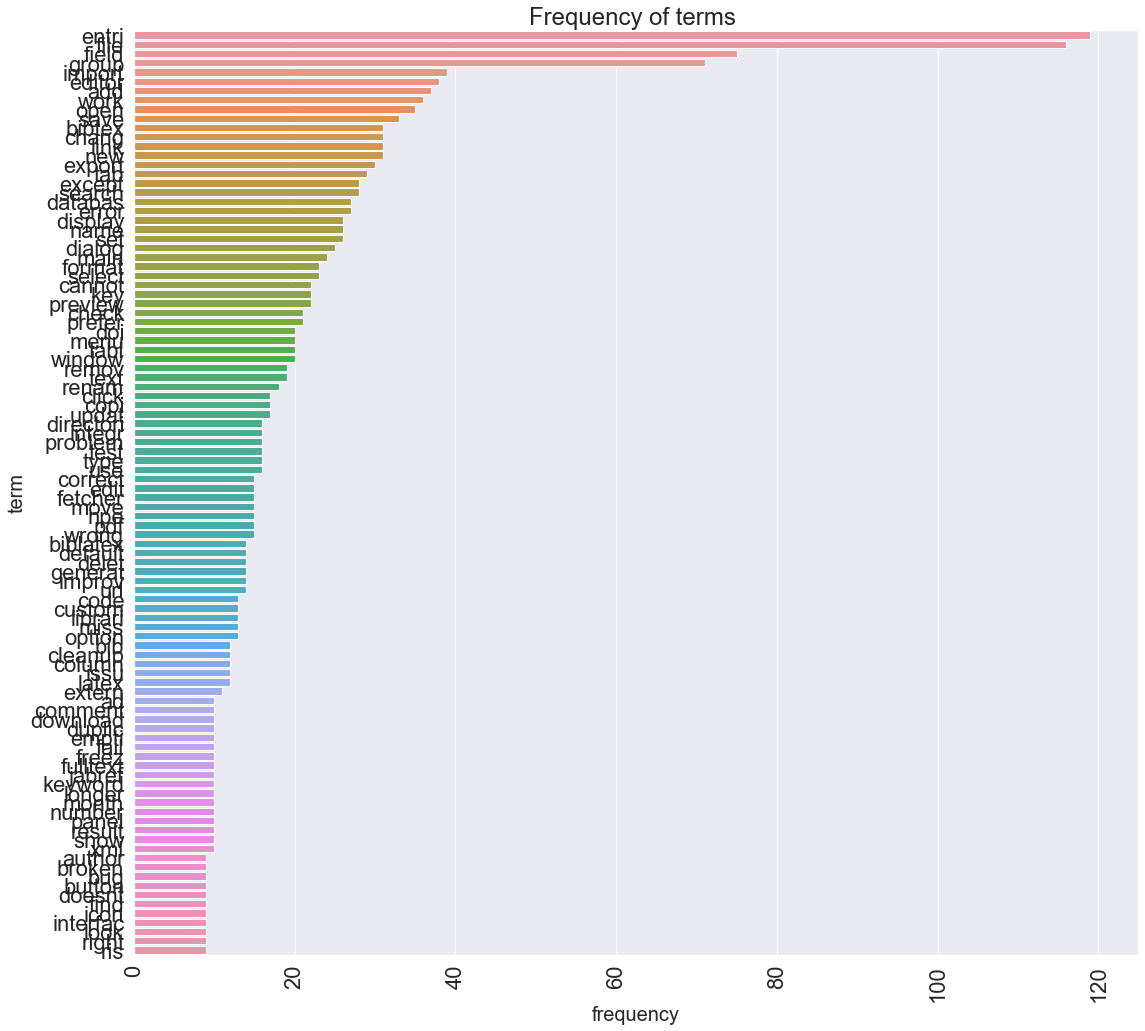

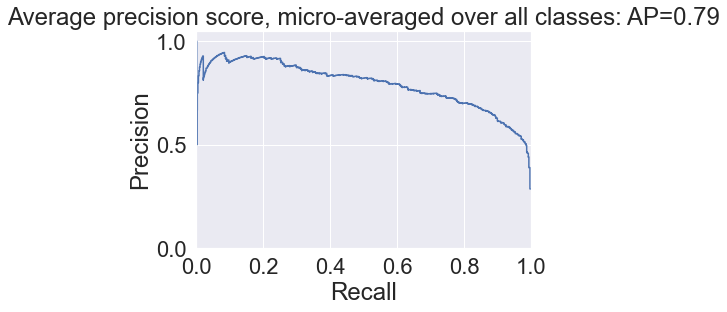

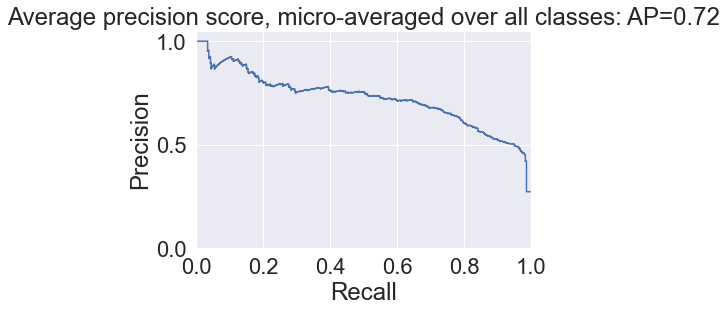

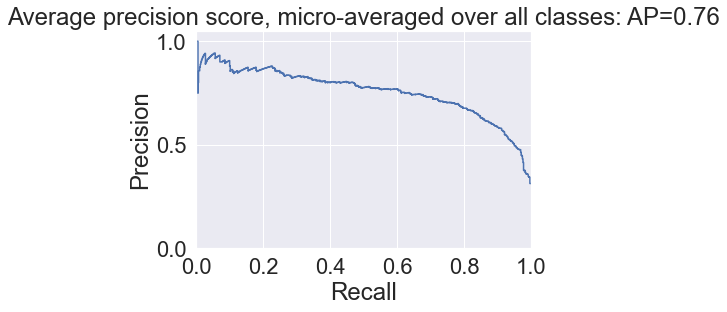

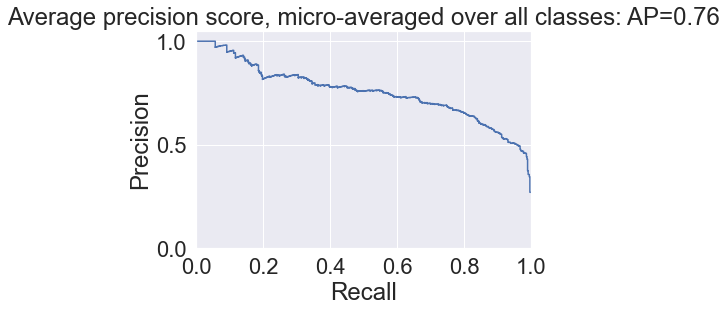

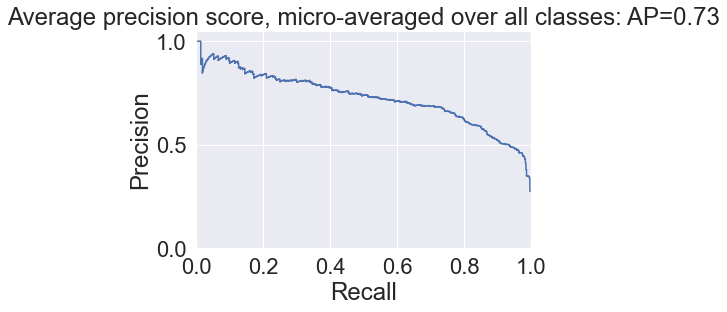

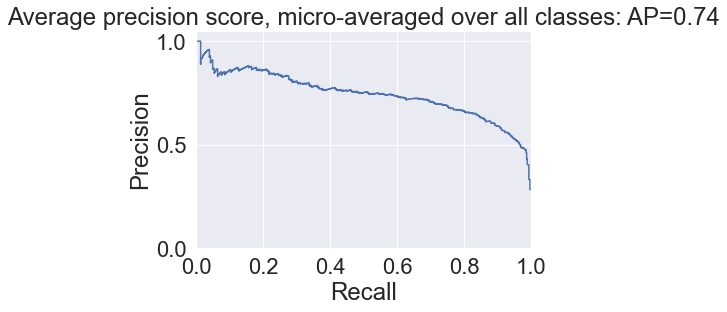

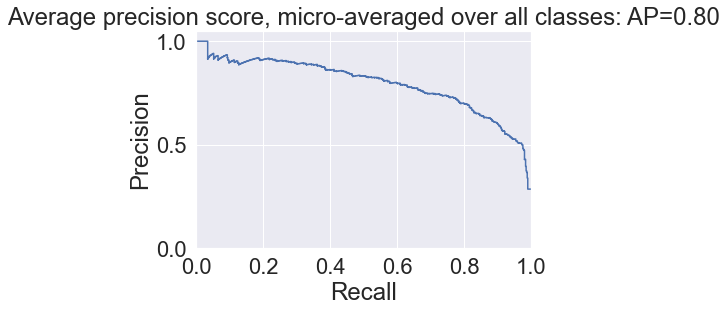

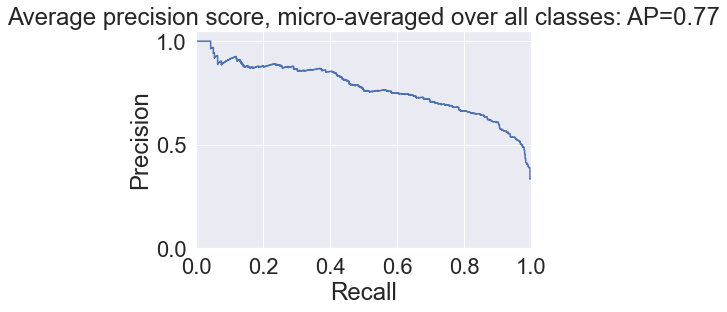

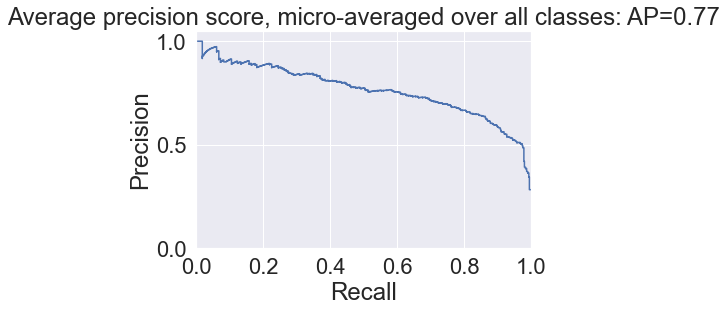

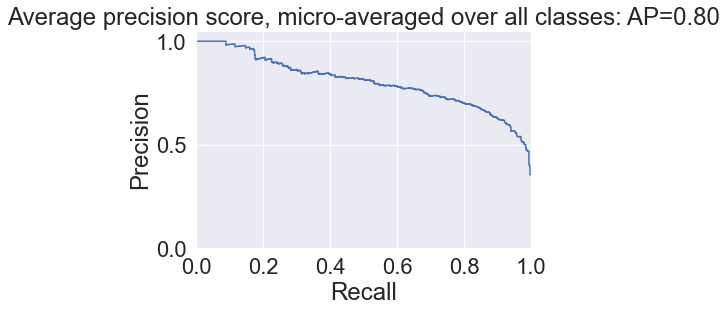

In [22]:
__main__()
